In [3]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
key = '6pQ1XOFvDCRG0DpNsdgIhcyiCmfUafzMzPETHn3K'

In [2]:
# national robbery 2012-2022

national_url = f'https://api.usa.gov/crime/fbi/cde/nibrs/national/robbery?from=1-2012&type=Counts&to=12-2022&API_KEY={key}'

response = requests.get(national_url)
if response.status_code == 200:
    national = response.json()
else:
    print(f"Error: {response.status_code}")

In [3]:
national.get('victim').get('location')

{'victim': {'age': {'0-9': 6818,
   '10-19': 160410,
   '20-29': 354698,
   '30-39': 234768,
   '40-49': 157054,
   '50-59': 124766,
   '60-69': 62371,
   '70-79': 18980,
   '80-89': 5864,
   'Unknown': 8082,
   '90-Older': 972},
  'sex': {'Male': 735628,
   'Female': 395723,
   'Unknown': 3432,
   'Not Specified': 199070},
  'race': {'Asian': 40950,
   'White': 670286,
   'Unknown': 42670,
   'Multiple': 0,
   'Not Specified': 199070,
   'Black or African American': 366800,
   'American Indian or Alaska Native': 9407,
   'Native Hawaiian or Other Pacific Islander': 4670,
   'Asian, Native Hawaiian, or Other Pacific Islander': 0},
  'location': {'Rest Area': 732,
   'Cyberspace': 0,
   'Restaurant': 57118,
   'Field/Woods': 8640,
   'Liquor Store': 8745,
   'Tribal Lands': 65,
   'Bar/Nightclub': 9578,
   'Farm Facility': 97,
   'Not Specified': 0,
   'Other/Unknown': 43827,
   'Shopping Mall': 6451,
   'Amusement Park': 290,
   'Residence/Home': 248894,
   'School/College': 1265,
   '

In [39]:
# Maya - work on most robbed locations by state

# california robbery 2012-2022

cali_url = 'https://api.usa.gov/crime/fbi/cde/nibrs/state/CA/robbery?from=1-2012&to=12-2022&API_KEY=6pQ1XOFvDCRG0DpNsdgIhcyiCmfUafzMzPETHn3K'

response = requests.get(cali_url)
if response.status_code == 200:
    cali = response.json()
else:
    print(f"Error: {response.status_code}")

In [74]:
crimescene = cali.get('victim').get('location').keys()
crimescene = {}

link1 = cali_url[:46]
link2 = cali_url[48:]

states = ["AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "IA",
    "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME", "MI", "MN", "MO",
    "MS", "MT", "NC", "ND", "NE", "NH", "NJ", "NM", "NV", "NY", "OH", "OK",
    "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI",
    "WV", "WY"]

for state in states:
    link = link1 + state + link2
    response = requests.get(link)
    if response.status_code == 200:
        link = response.json()
        crimescene[f'{state}'] = (pd.Series(link.get('victim').get('location')))
    else:
        print(f"Error: {response.status_code}")


# print(crimescene)

# nth most common crime scene for each state
def index_common(crimescene, n=1):
    if n < 1 or n > len(crimescene):
        print ("Index out of range")
    crimescene_df = pd.DataFrame(crimescene).T.fillna(0)
    nth_common = crimescene_df.apply(lambda col: col.nlargest(n).index[-1])
    return nth_common 

commoncrimescene = index_common(crimescene, 1).reset_index()
commoncrimescene.columns = ['MostCommonCrimeScene', 'State']

print(commoncrimescene)

                             MostCommonCrimeScene State
0                                       Rest Area    MI
1                                      Cyberspace    AK
2                                      Restaurant    TX
3                                     Field/Woods    TX
4                                    Liquor Store    CO
5                                    Tribal Lands    AZ
6                                   Bar/Nightclub    TX
7                                   Farm Facility    CA
8                                   Not Specified    AK
9                                   Other/Unknown    OH
10                                  Shopping Mall    TX
11                                 Amusement Park    TX
12                                 Residence/Home    TN
13                                 School/College    WA
14                                Camp/Campground    OR
15                                Industrial Site    OH
16                                Park/Playgroun

In [ ]:
crimescene = cali.get('victim').get('location').keys()
crimescene = {}

link1 = cali_url[:46]
link2 = cali_url[48:]

states = ["AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "IA",
          "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME", "MI", "MN", "MO",
          "MS", "MT", "NC", "ND", "NE", "NH", "NJ", "NM", "NV", "NY", "OH", "OK",
          "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI",
          "WV", "WY"]

for state in states:
    link = link1 + state + link2
    response = requests.get(link)
    if response.status_code == 200:
        link = response.json()
        crimescene[f'{state}'] = (pd.Series(link.get('victim').get('location')))
    else:
        print(f"Error: {response.status_code}")

In [98]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [127]:
crimescene_df = pd.DataFrame(crimescene).T.fillna(0)
state_colors = crimescene_df.apply('idxmax', axis=1)
state_colors = state_colors.reset_index()
state_colors.columns = ['State', 'MostCommonCrimeScene']

crime_scenes = state_colors['MostCommonCrimeScene'].unique()
color_map = {scene: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
             for i, scene in enumerate(crime_scenes)}

state_colors['Color'] = state_colors['MostCommonCrimeScene'].map(color_map)

In [135]:
state_colors['Color'].unique()

array(['#636EFA', '#EF553B', '#00CC96', '#AB63FA'], dtype=object)

In [136]:
fig = px.choropleth(locations=state_colors['State'],
                    color=state_colors['MostCommonCrimeScene'],
                    locationmode='USA-states',
                    scope='usa',
                    color_discrete_map=dict(
                        zip(crime_scenes, state_colors['Color'].unique())),
                    )

fig.show()

In [138]:
import plotly.io as pio
pio.write_html(fig, file='choropleth_map.html', auto_open=True)

In [107]:
# Create the choropleth map
fig = go.Figure(data=go.Choropleth(
    locations=state_colors['State'],  # Spatial coordinates
    z=state_colors['MostCommonCrimeScene'].astype(
        str),  # Data to be color-coded
    locationmode='USA-states',  # Set of locations match entries in `locations`
    colorscale=[[0, color_map[scene]] for scene in crime_scenes],  # Color scale
    colorbar_title="Crime Scene",
))

# Update layout for the map
fig.update_layout(
    title_text='Most Common Crime Scene by State',
    geo_scope='usa',  # Limit map scope to USA
)

# Show the plot
fig.show()

In [41]:
# this isn't working very well i'm going to try something else

import plotly.express as px

fig = px.choropleth(
    commoncrimescene, 
    locations='State', 
    locationmode='USA-states', 
    color='MostCommonCrimeScene', 
    scope='usa',
    title=f'Most Common Crime Scene by State',
    color_discrete_sequence=px.colors.qualitative.Set3  
)

fig.show()

In [44]:
# Indi - work on robbery rate vs law enforcement employees by year

# employees 2012-2022

employees_url  = f'https://api.usa.gov/crime/fbi/cde/pe?from=2012&to=2022&API_KEY={key}'

response = requests.get(employees_url)
if response.status_code == 200:
    employees = response.json()
else:
    print(f"Error: {response.status_code}")

In [49]:
male = employees.get('actuals').get('Male Officers').values()
female = employees.get('actuals').get('Female Officers').values()

In [70]:
per = employees.get('rates').get('Officers per 1,000 People').values()

In [4]:
# national robbery 2012-2022 by year

base_url = 'https://api.usa.gov/crime/fbi/cde/nibrs/national/robbery?from={}&type=Counts&to={}&API_KEY=' + key

rob_by_year = {}

for year in range(2012, 2023):
    url = base_url.format(f'1-{year}', f'12-{year}')
    response = requests.get(url)
    if response.status_code == 200:
        rob_by_year[year] = response.json()
    else:
        print(f"Error: {response.status_code}")


In [71]:
rob_per_year = []

for year in range(2012, 2023):
    rob_per_year.append(
        sum(rob_by_year.get(year).get('victim').get('sex').values()))

employees_df = pd.DataFrame([range(2012, 2023), rob_per_year, male, female, per]).T
employees_df.columns = ['Year', 'Robberies', 'Male_Officers', 'Female_Officers', 'Officers_per_1k']
employees_df.set_index('Year', inplace=True)
employees_df.to_csv('employees.csv')

NameError: name 'male' is not defined

In [37]:
employees_df = pd.read_csv('employees.csv')

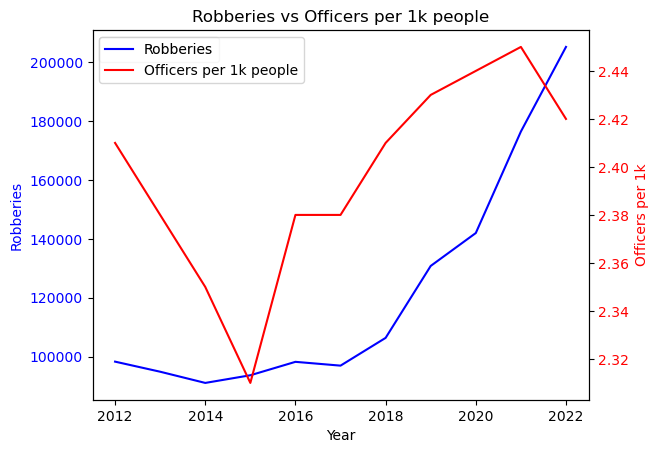

0.6648185233967915


In [38]:
fig, ax1 = plt.subplots()

# Plot the 'Robberies' on the left y-axis
sns.lineplot(data=employees_df, x='Year', y='Robberies',
             ax=ax1, label='Robberies', color='b')
ax1.set_ylabel('Robberies', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the 'Officers_per_1k' on the right y-axis
sns.lineplot(data=employees_df, x='Year', y='Officers_per_1k',
             ax=ax2, label='Officers per 1k people', color='r')
ax2.set_ylabel('Officers per 1k', color='r')
ax2.tick_params(axis='y', labelcolor='r')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper left')
plt.title('Robberies vs Officers per 1k people')

plt.show()
print(employees_df.Robberies.corr(employees_df.Officers_per_1k))

In [6]:
# national robbery 2012-2022 by month

base_url = 'https://api.usa.gov/crime/fbi/cde/nibrs/national/robbery?from={}&type=Counts&to={}&API_KEY=' + key

rob_month = {}

for year in range(2012, 2023):
    for month in range(1, 13):
        url = base_url.format(f'{month}-{year}', f'{month}-{year}')
        response = requests.get(url)
        if response.status_code == 200:
            rob_month[f'{month}-{year}'] = response.json()
        else:
            print(f"Error: {response.status_code}")

In [99]:
month_list = {}

for year in range(2012, 2023):
    for month in range(1, 13):
        month_list[f'{month}-{year}'] = (pd.Series(rob_month.get(
            f'{month}-{year}').get('offense').get('weapons')))

weapons_df = pd.DataFrame(month_list).T
weapons_df.to_csv('weapons.csv', index_label='Date')

In [42]:
weapons_df = pd.read_csv('weapons.csv')
weapons_df.Date = pd.to_datetime(weapons_df.Date, format='%m-%Y')
weapons_df.set_index('Date', inplace=True)

In [43]:
weapons_df.sum(axis=0).sort_values(ascending=False)

Handgun                            313211
Personal Weapons                   303741
None                                97963
Firearm                             81801
Knife/Cutting Instrument            80929
Other                               40826
Unknown                             34662
Blunt Object                        29678
Handgun (Automatic)                 18331
Rifle                                7848
Shotgun                              6709
Other Firearm                        6571
Motor Vehicle/Vessel                 5196
Firearm (Automatic)                  3832
Asphyxiation                         1004
Rifle (Automatic)                     741
Explosives                            591
Poison                                555
Other Firearm (Automatic)             293
Drugs/Narcotics/Sleeping Pills        281
Fire/Incendiary Device                275
Shotgun (Automatic)                    90
Drowning                                0
Unarmed                           

In [44]:
weapons_df['Firearm'] = weapons_df[['Firearm', 'Rifle', 'Handgun', 'Shotgun', 'Other Firearm']].sum(axis=1)
weapons_df.drop(['Rifle', 'Handgun', 'Shotgun', 'Other Firearm'], axis=1, inplace=True)

In [45]:
weapons_df['Firearm (Automatic)'] = weapons_df[['Rifle (Automatic)', 'Handgun (Automatic)', 'Shotgun (Automatic)', 'Firearm (Automatic)', 'Other Firearm (Automatic)']].sum(axis=1)
weapons_df.drop(['Rifle (Automatic)', 'Handgun (Automatic)', 'Shotgun (Automatic)', 'Other Firearm (Automatic)'], axis=1, inplace=True)

In [46]:
weapons_df['Unknown'] = weapons_df[['Unknown', 'None']].sum(axis=1)
weapons_df.drop(['None'], axis=1, inplace=True)

In [47]:
weapons_df.drop(['Pushed or Thrown Out Window', 'Unarmed', 'Drowning', 'Lethal Cutting Instrument', 'Club/Blackjack/Brass Knuckles',
                'Strangulation - Include Hanging', 'Drugs/Narcotics/Sleeping Pills', 'Fire/Incendiary Device', 'Poison'], axis=1, inplace=True)

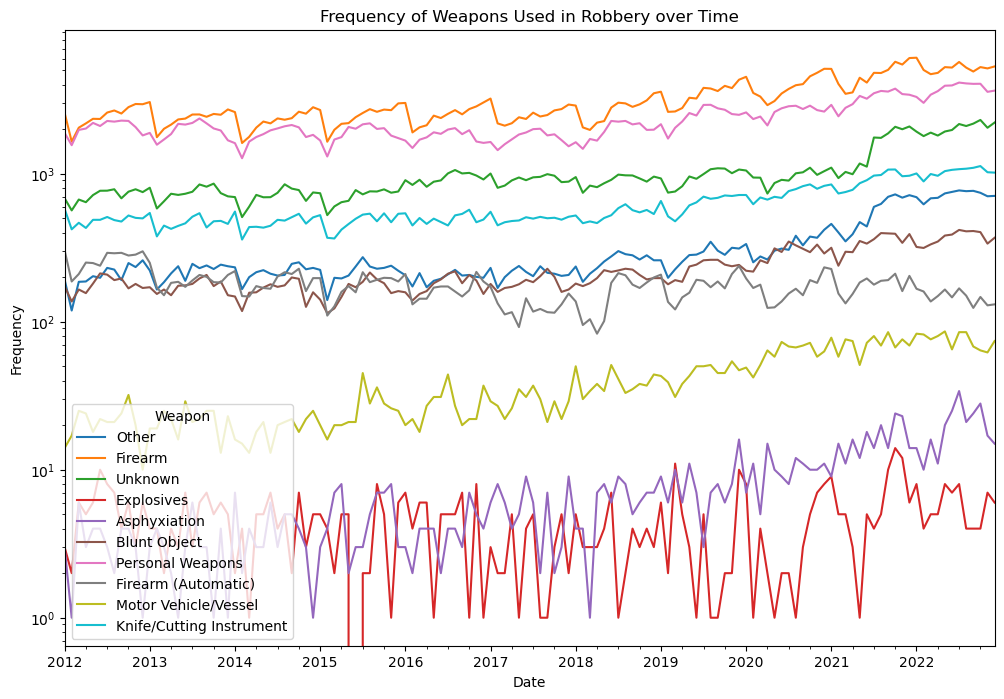

In [49]:
weapons_df.plot(kind='line', figsize=(12, 8))

plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Frequency of Weapons Used in Robbery over Time')
plt.legend(title='Weapon', loc='lower left')
plt.yscale('log')

plt.show()

In [31]:
years = list(range(2012, 2023))
age_30_plus = {year: 0 for year in years}
age_29_or_less = {year: 0 for year in years}

for year in years:

    for age in rob_by_year[year].get('offender').get('age'):
        if age == '0-9' or age == '10-19' or age == '20-29':
            age_29_or_less[year] += rob_by_year[year].get(
                'offender').get('age').get(age)
        elif age != 'Unkown':
            age_30_plus[year] += rob_by_year[year].get(
                'offender').get('age').get(age)

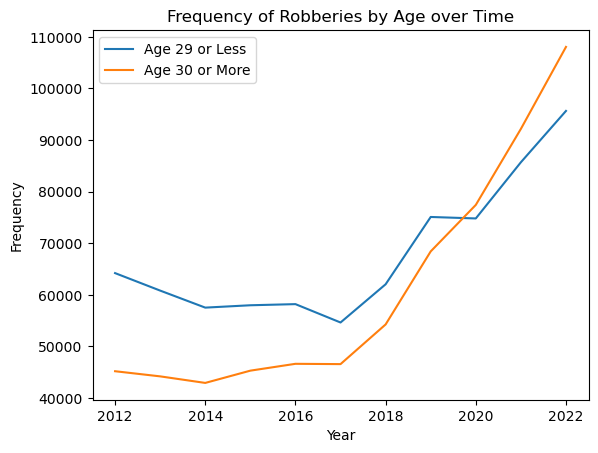

In [35]:
sns.lineplot(x=years, y=list(age_29_or_less.values()), label='Age 29 or Less')
sns.lineplot(x=years, y=list(age_30_plus.values()), label='Age 30 or More')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Robberies by Age over Time')
plt.show()

In [34]:
t_stat, p_value = ttest_ind(
    list(age_30_plus.values()), list(age_29_or_less.values()), alternative='greater')

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

T-Statistic: -0.8707766606491733
P-Value: 0.8028958246288136


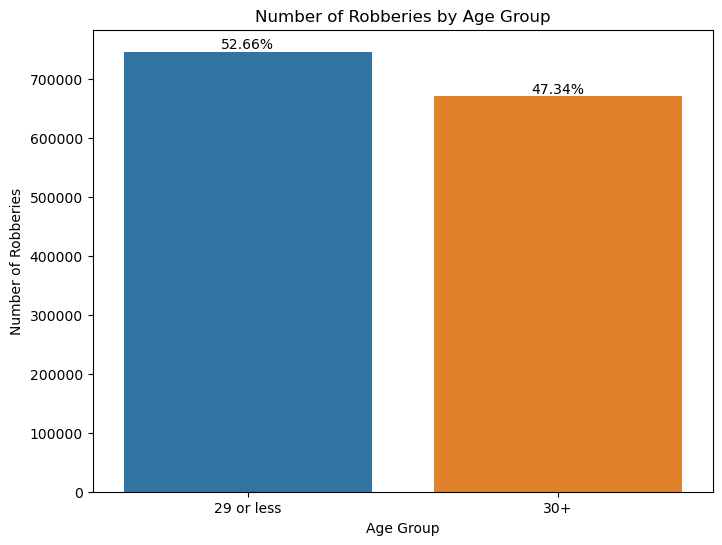

In [72]:
sum_30_plus = sum(list(age_30_plus.values()))
sum_29_or_less = sum(list(age_29_or_less.values()))

total_sum = sum_30_plus + sum_29_or_less

prop_30_plus = sum_30_plus / total_sum
prop_29_or_less = sum_29_or_less / total_sum

data = {
    'Age Group': ['29 or less', '30+'],
    'Actuals': [sum_29_or_less, sum_30_plus],
    'Proportion of Robberies': [prop_29_or_less, prop_30_plus]
}
df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Age Group', y='Actuals', data=df, hue='Age Group')

for state, row in df.iterrows():
    ax.text(state, row['Actuals'] + 5000.0,
            f"{row['Proportion of Robberies']:.2%}", ha='center')

plt.xlabel('Age Group')
plt.ylabel('Number of Robberies')
plt.title('Number of Robberies by Age Group')

plt.show()